Assignment Four - CRISP-DM Capstone: Association Rule Mining, Clustering, or Collaborative Filtering
===
##Hector Curi - Spencer Kaiser

---
Instructions
---
In the final assignment for this course, you will be using one of three different analysis methods:

* Option A: Use transaction data for mining associations rules
* Option B: Use clustering on an unlabeled dataset to provide insight or features
* Option C: Use collaborative filtering to build a custom recommendation system

Your choice of dataset will largely determine the task that you are trying to achieve. Though the dataset does not need to change from your previous tasks. For example, you might choose to use clustering on your data as a preprocessing step that extracts different features. Then you can use those features to build a classifier and analyze its performance in terms of accuracy (precision, recall) and speed. Alternatively, you might choose a completely different dataset and perform rule mining or build a recommendation system.

---
Dataset Selection and Toolkits
---
As before, you need to choose a dataset that is not small. It might be massive in terms of the number of attributes (or transactions), classes (or items, users, etc.) or whatever is appropriate for the task you are performing. Note that scikit-learn can be used for clustering analysis, but not for Association Rule Mining (you should use R) or collaborative filtering (you should use graphlab-create from Dato). Both can be run using iPython notebooks as perfomed in class.

Write a report covering in detail all the steps of the project. The results need to be reproducible using only this report. Describe all assumptions you make and include all code you use in the iPython notebook or as supplemental functions. Follow the CRISP-DM framework in your analysis (you are performing all of the CRISP-DM outline). This report is worth 20% of the final grade.

---
### Choice of Task
We are going to use the MovieLens movie ratings dataset to complete **Option C**. We plan on utilizing over 100,000 user ratings of 8,570 movies to create a user-item collaborative filtering recommendation system.

---
### Initial Code
Our first task was to create a usable dataset from the individual files created by MovieLens. We accomplished this by using the pandas `merge` function, then we wrote the result to a new file called `data.csv`. Each instance in this file now contains the id of both the user and the movie, the movie title, its rating, genres, and more.

In [1]:
#import all packages used in this assignment
import graphlab as gl
import graphlab.aggregate as agg
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from numpy import random as rd
from sklearn import metrics as mt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

# read in the separate csv files (ratings and movies) and combine them into one for easier use
df1 = pd.read_csv('data/ratings.csv')
df2 = pd.read_csv('data/movies.csv')
merged = df1.merge(df2, on="movieId", how="outer").fillna("")
merged.to_csv("data/data.csv", index=False)

# read in final merged file as both an sframe and a dataframe
data = gl.SFrame.read_csv("data/data.csv")
# embed graphs to ipython
gl.canvas.set_target('ipynb')

A newer version of GraphLab Create (v1.4.0) is available! Your current version is v1.3.0.
New features in 1.4:
- Nearest neighbor classifier
- Label propagation toolkit
- Model visualization in GraphLab Canvas
- New model parameter search API
- New feature engineering transformers (TF-IDF and Numeric Imputation)
- Java and JavaScript client libraries for Predictive Service
- Support deploying scikit-learn models to Predictive Service

Significant speedup and improvements in 1.4:
- Faster SFrame execution with query optimization 
- Pagerank and ConnectedComponents
- K-Means with large K 
- GraphLab Canvas histograms and heat map
- Better cache control for Predictive Service

For detailed release notes please visit:
https://dato.com/products/create/release-notes.htmlYou can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.[INFO] Start server at: ipc:///tmp/graphlab_server-1066 - Server binary: /Library/Python/2.7/site-packa

PROGRESS: Finished parsing file /Users/hcuri/Dropbox/SMU/Classes/ CSE 5331 - Data Mining/Assignments/DataMining/04_AssignmentFour/data/data.csv
PROGRESS: Parsing completed. Parsed 100 lines in 0.156648 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[float,float,float,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /Users/hcuri/Dropbox/SMU/Classes/ CSE 5331 - Data Mining/Assignments/DataMining/04_AssignmentFour/data/data.csv
PROGRESS: Parsing completed. Parsed 100041 lines in 0.131768 secs.


Business Understanding
---

---
### 1. Business Purpose & Implications of Analysis (10 points)
**Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm and why does this method make sense for this specific dataset and the stakeholders needs?**

We chose the MovieLens Data Set from Department of Computer Science and Engineering at the University of Minnesota, Twin Cities at http://grouplens.org/datasets/movielens/.

The primary purpose of this dataset, and it’s creation, is for research purposes. Other similar datasets have been made, however, these datasets were primarily made available for competition purposes in order to improve a business’s recommendation model.

Regarding how an analysis of this data set may be used in the real-world, one of the most beneficial uses of the resulting system would be for movie streaming services like Netflix. Netflix is constantly adding new movies to their offering that they believe will be in high demand. At the same time, they are constantly removing under-performing titles. They do this in order to maximize the revenue generated from each title after paying licensing fees, to make sure their offering remains current and relevant, and they also do this to ensure that users of the service are happy with what they are paying for. 

Our recommendation system could be used to help Netflix fine-tune their offering to best meet the needs of their current subscribers. It could be used to help identify new movies that may be popular and it could also be used to help determine which movies are the least popular.

We will use cross validation to measure the effectiveness of our algorithm. Using precision and recall, we can estimate how many of our recommender system predictions are correct and how many don't match our testing set.

Data Understanding
---

---
### 1. Data Meaning (10 points)
**Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?**

Attribute | Type | Range / Values | Description 
--- | --- | --- | ---
userId | Nominal | 1 - 706 | Randomly assigned user ID's
movieId | Nominal | 1 - 129651 | Randomly assigned movie ID's
rating | Ordinal | 0.5 - 5.0 | Individual rating given to each movie by a user 
timestamp | Interval | 828504918 - 1427754939 | Represent how many seconds after midnight Coordinated Universal Time (UTC) of January 1, 1970 the rating was made
title | Nominal | N/A | Title of the movie 
genres | Nominal | Action, Adventure, Animation, Children’s, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western, N/A '(no genres listed)' | Genre or genres assigned to each movie 


Data collection for this dataset began in April of 1996. Since then, the data set has gone through multiple iterations and the result is a high-quality, well-polished dataset. The dataset does not contain missing values in the traditional sense, however, according to the creators of the dataset “Only movies with at least one rating or tag are included in the dataset”, so some instances have missing values for the ratings field. Because the the quantity of these types of instances is low and because we are primarily focusing on rating, we will be removing these instances from the data set.

In [2]:
#here we drop all the rows that have missing values, which are basically the bottom 18 rows that are movies without ratings
data = data.dropna()

In [3]:
# Use the head to get a general idea of how the data in our data set looks like
data.head()

userId,movieId,rating,timestamp,title,genres
1.0,6.0,2.0,980730861.0,Heat (1995),Action|Crime|Thriller
8.0,6.0,5.0,964736358.0,Heat (1995),Action|Crime|Thriller
9.0,6.0,3.0,844674216.0,Heat (1995),Action|Crime|Thriller
16.0,6.0,2.0,855198917.0,Heat (1995),Action|Crime|Thriller
19.0,6.0,4.0,1154985045.0,Heat (1995),Action|Crime|Thriller
21.0,6.0,4.0,865106909.0,Heat (1995),Action|Crime|Thriller
31.0,6.0,5.0,1186249974.0,Heat (1995),Action|Crime|Thriller
60.0,6.0,5.0,1264525122.0,Heat (1995),Action|Crime|Thriller
87.0,6.0,5.0,848503814.0,Heat (1995),Action|Crime|Thriller
96.0,6.0,5.0,882593416.0,Heat (1995),Action|Crime|Thriller


Furthermore, there are no apparent outliers in the set. The scale users rank movies on allows values from 0.5 to 5.0 with increments of 0.5. After running a `min` and a `max` of the dataset, we can see there are no incorrect values (outliers in this case) for the ratings field. Lastly, the dataset contains no duplicate instances.

---
### 2. Visualization of Attributes (10 points)
**Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.**

Here is a general breakdown of our data provided by the Graphlab library.

In [4]:
data.show()

<IPython.core.display.Javascript object>

This next graph shows the distribution of ratings in our data set.

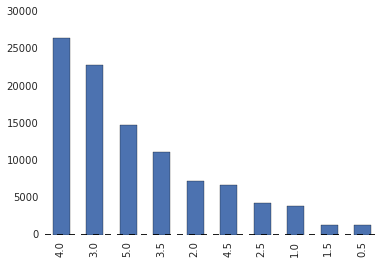

In [5]:
df = data.to_dataframe()
df['rating'].value_counts().plot(kind='bar')

As we can see most ratings were 4's and 3's, followed by 5's. The least amount of ratings were 0.5's and 1.5s'.

This was very unexpected for us. We had an initial hypthesis that the ratings were going to be mostly 5's and 1's, based on our belief that most people either hate or love the movies they rate. But apparently not.

We think that this distribution now makes sense after reflecting a bit and realizing that people tend to watch movies that are of somewhat interest to them and thus very hard to completely hate. This then causes them to evaluate them from a perfect movie at a 5 rating and downward, causing these many 4's and 3's. Ratings of 1's and lower probably were not given that much because the user probably wouldn't even watch movies that are so different from their tastes, thus explaining their low frequency.

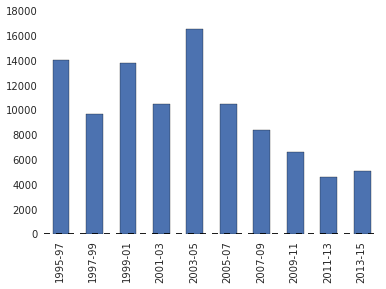

In [6]:
df['time_range'] = pd.cut(df.timestamp,[828504917,891576917,954648917,1017720917,1080792917,1143864917,1206936917,1270008917,1333080917,1396152917,1427754940],10,labels=['1995-97','1997-99','1999-01','2001-03','2003-05','2005-07','2007-09','2009-11','2011-13','2013-15'])
df['time_range'].value_counts(sort = False).plot(kind='bar')

The graph above shows when the ratings were made according to their timestamps.

We can see that the most ratings were done on the period from 2003 to 2005, and have declined since. There is a slight increase in the last period of 2013-15.

In [7]:
numRatings = data['title']
numRatings.show()

<IPython.core.display.Javascript object>

In [8]:
numRatingsPerPerson = data['userId']
numRatingsPerPerson.show()

<IPython.core.display.Javascript object>

In [9]:
df = data.to_dataframe()
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,6,2,980730861,Heat (1995),Action|Crime|Thriller
1,8,6,5,964736358,Heat (1995),Action|Crime|Thriller
2,9,6,3,844674216,Heat (1995),Action|Crime|Thriller
3,16,6,2,855198917,Heat (1995),Action|Crime|Thriller
4,19,6,4,1154985045,Heat (1995),Action|Crime|Thriller


Modeling and Evaluation (50 points)
---

Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.

---
### 1. WRITE TITLE
**Create user-item matrices or item-item matrices using collaborative filtering**

In [10]:
data['userId'] = data['userId'].astype(str)
data['movieId'] = data['movieId'].astype(str)


model = gl.recommender.create(data, user_id="userId", item_id="movieId", target="rating")
results = model.recommend(users=None, k=5)
model.save("movie_recommender")

results.head() # the recommendation output

PROGRESS: Recsys training: model = ranking_factorization_recommender
PROGRESS: Preparing data set.
PROGRESS:     Data has 100023 observations with 706 users and 8552 items.
PROGRESS:     Data prepared in: 0.211124s
PROGRESS: Training ranking_factorization_recommender for recommendations.
PROGRESS: +--------------------------------+--------------------------------------------------+----------+
PROGRESS: | Parameter                      | Description                                      | Value    |
PROGRESS: +--------------------------------+--------------------------------------------------+----------+
PROGRESS: | num_factors                    | Factor Dimension                                 | 32       |
PROGRESS: | regularization                 | L2 Regularization on Factors                     | 1e-09    |
PROGRESS: | solver                         | Solver used for training                         | adagrad  |
PROGRESS: | linear_regularization          | L2 Regularization on Lin

userId,movieId,score,rank
1,2959,5.29865447794,1
1,47,5.19648234163,2
1,6377,5.06464652334,3
1,6539,5.0418307892,4
1,4886,5.01878694807,5
8,3578,5.32818944369,1
8,858,5.25128079568,2
8,50,5.24195320521,3
8,47,5.18652589236,4
8,4886,5.18584127341,5


---
### 2. WRITE TITLE
**Determine performance of the recommendations using different performance measures.**

---
### 3. WRITE TITLE
**Use tables/visualization to discuss the found results.**

---
### 4. WRITE TITLE
**Describe your results. What findings are the most compelling and why?**

Deployment (10 points)
---
Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you acheive your goals? If not, can you reign in the utility of your modeling?

---
### 1. WRITE TITLE
**How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?**

---
### 2. WRITE TITLE
**How would your deploy your model for interested parties?**

---
### 3. WRITE TITLE
**What other data should be collected?**

---
### 4. WRITE TITLE
**How often would the model need to be updated, etc.?**

Exceptional Work (10 points)
---

---
**You have free reign to provide additional analyses or combine analyses**

In [ ]:
                                 .''.
       .''.             *''*    :_\/_:     .
      :_\/_:   .    .:.*_\/_*   : /\ :  .'.:.'.
  .''.: /\ : _\(/_  ':'* /\ *  : '..'.  -=:o:=-
 :_\/_:'.:::. /)\*''*  .|.* '.\'/.'_\(/_'.':'.'
 : /\ : :::::  '*_\/_* | |  -= o =- /)\    '  *
  '..'  ':::'   * /\ * |'|  .'/.\'.  '._____
      *        __*..* |  |     :      |.   |' .---"|
       _*   .-'   '-. |  |     .--'|  ||   | _|    |
    .-'|  _.|  |    ||   '-__  |   |  |    ||      |
    |' | |.    |    ||       | |   |  |    ||      |
 ___|  '-'     '    ""       '-'   '-.'    '`      |____